# Language Detection ML Project
Isabella Sturm

2022-02-17

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load sentence data
all_languages_df = pd.read_csv('sentences.csv', '\t', names=['Index','Code','Sentence'])
all_languages_df.head()

,Index,Code,Sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [3]:
# Load language codes
lang_codes_df = pd.read_csv('iso-639-3.tab', '\t')
lang_codes_df = lang_codes_df.drop(['Part2B','Part2T', 'Part1','Comment'], axis=1)
lang_codes_df.head()

,Id,Scope,Language_Type,Ref_Name
0,aaa,I,L,Ghotuo
1,aab,I,L,Alumu-Tesu
2,aac,I,L,Ari
3,aad,I,L,Amal
4,aae,I,L,Arbëreshë Albanian


In [4]:
# Top 25 languages, per farandwide.com
top_languages = ['English',
                 'Mandarin Chinese',
                 'Spanish',
                 'Hindi',
                 'Arabic',
                 'Malay',
                 'Russian',
                 'Bengali',
                 'Portuguese',
                 'French',
                 'Hausa',
                 'Punjabi',
                 'German',
                 'Japanese',
                 'Persian',
                 'Swahili',
                 'Vietnamese',
                 'Telugu',
                 'Italian',
                 'Javanese',
                 'Wu Chinese',
                 'Korean',
                 'Tamil',
                 'Marathi',
                 'Yue Chinese']

In [5]:
# Join language codes with the languages/sentences dataframe
all_languages_codes_df = all_languages_df.set_index('Code').join(lang_codes_df.set_index('Id')).reset_index()
all_languages_codes_df.head()


,index,Index,Sentence,Scope,Language_Type,Ref_Name
0,\N,988328,.,NaN,NaN,NaN
1,\N,5412581,Selâmetle.,NaN,NaN,NaN
2,\N,5716114,Äänilani,NaN,NaN,NaN
3,\N,6473120,"Sābuku mamayamin, niyaꞋ takiteku manaꞋul magla...",NaN,NaN,NaN
4,\N,6481359,Kataau kano koson i Ama' min pana mataau!,NaN,NaN,NaN


In [6]:
top_languages_df = all_languages_codes_df[all_languages_codes_df['Ref_Name'].isin(top_languages)]
top_languages_df.head()


,index,Index,Sentence,Scope,Language_Type,Ref_Name
5859,ara,331919,ويل للكافرين,M,L,Arabic
5860,ara,332182,متى أنشئت هذه الجامعة؟,M,L,Arabic
5861,ara,332186,أراها نادراً,M,L,Arabic
5862,ara,332187,يعزف على البيانو بشكل جيد جداً,M,L,Arabic
5863,ara,332191,مع كل احترامي.,M,L,Arabic


In [7]:
print('Original DataSet: ', all_languages_codes_df.shape)
print('Filtered DataSet: ', top_languages_df.shape)

Original DataSet:  (10219662, 6)
Filtered DataSet:  (5555782, 6)


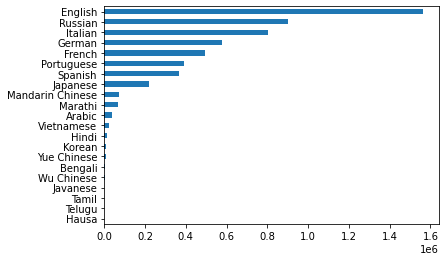

In [8]:
# Bar chart of value counts - how many sentences for each language
top_languages_df['Ref_Name'].value_counts()[:25]\
        .sort_values().plot(kind='barh')

In [9]:
top_languages_df['Ref_Name'].value_counts()[:25]

English             1564640
Russian              900863
Italian              801269
German               578833
French               493072
Portuguese           392730
Spanish              366050
Japanese             218246
Mandarin Chinese      71952
Marathi               68633
Arabic                38384
Vietnamese            20628
Hindi                 14558
Korean                 8906
Yue Chinese            6200
Bengali                4732
Wu Chinese             4716
Javanese                710
Tamil                   334
Telugu                  257
Hausa                    69
Name: Ref_Name, dtype: int64

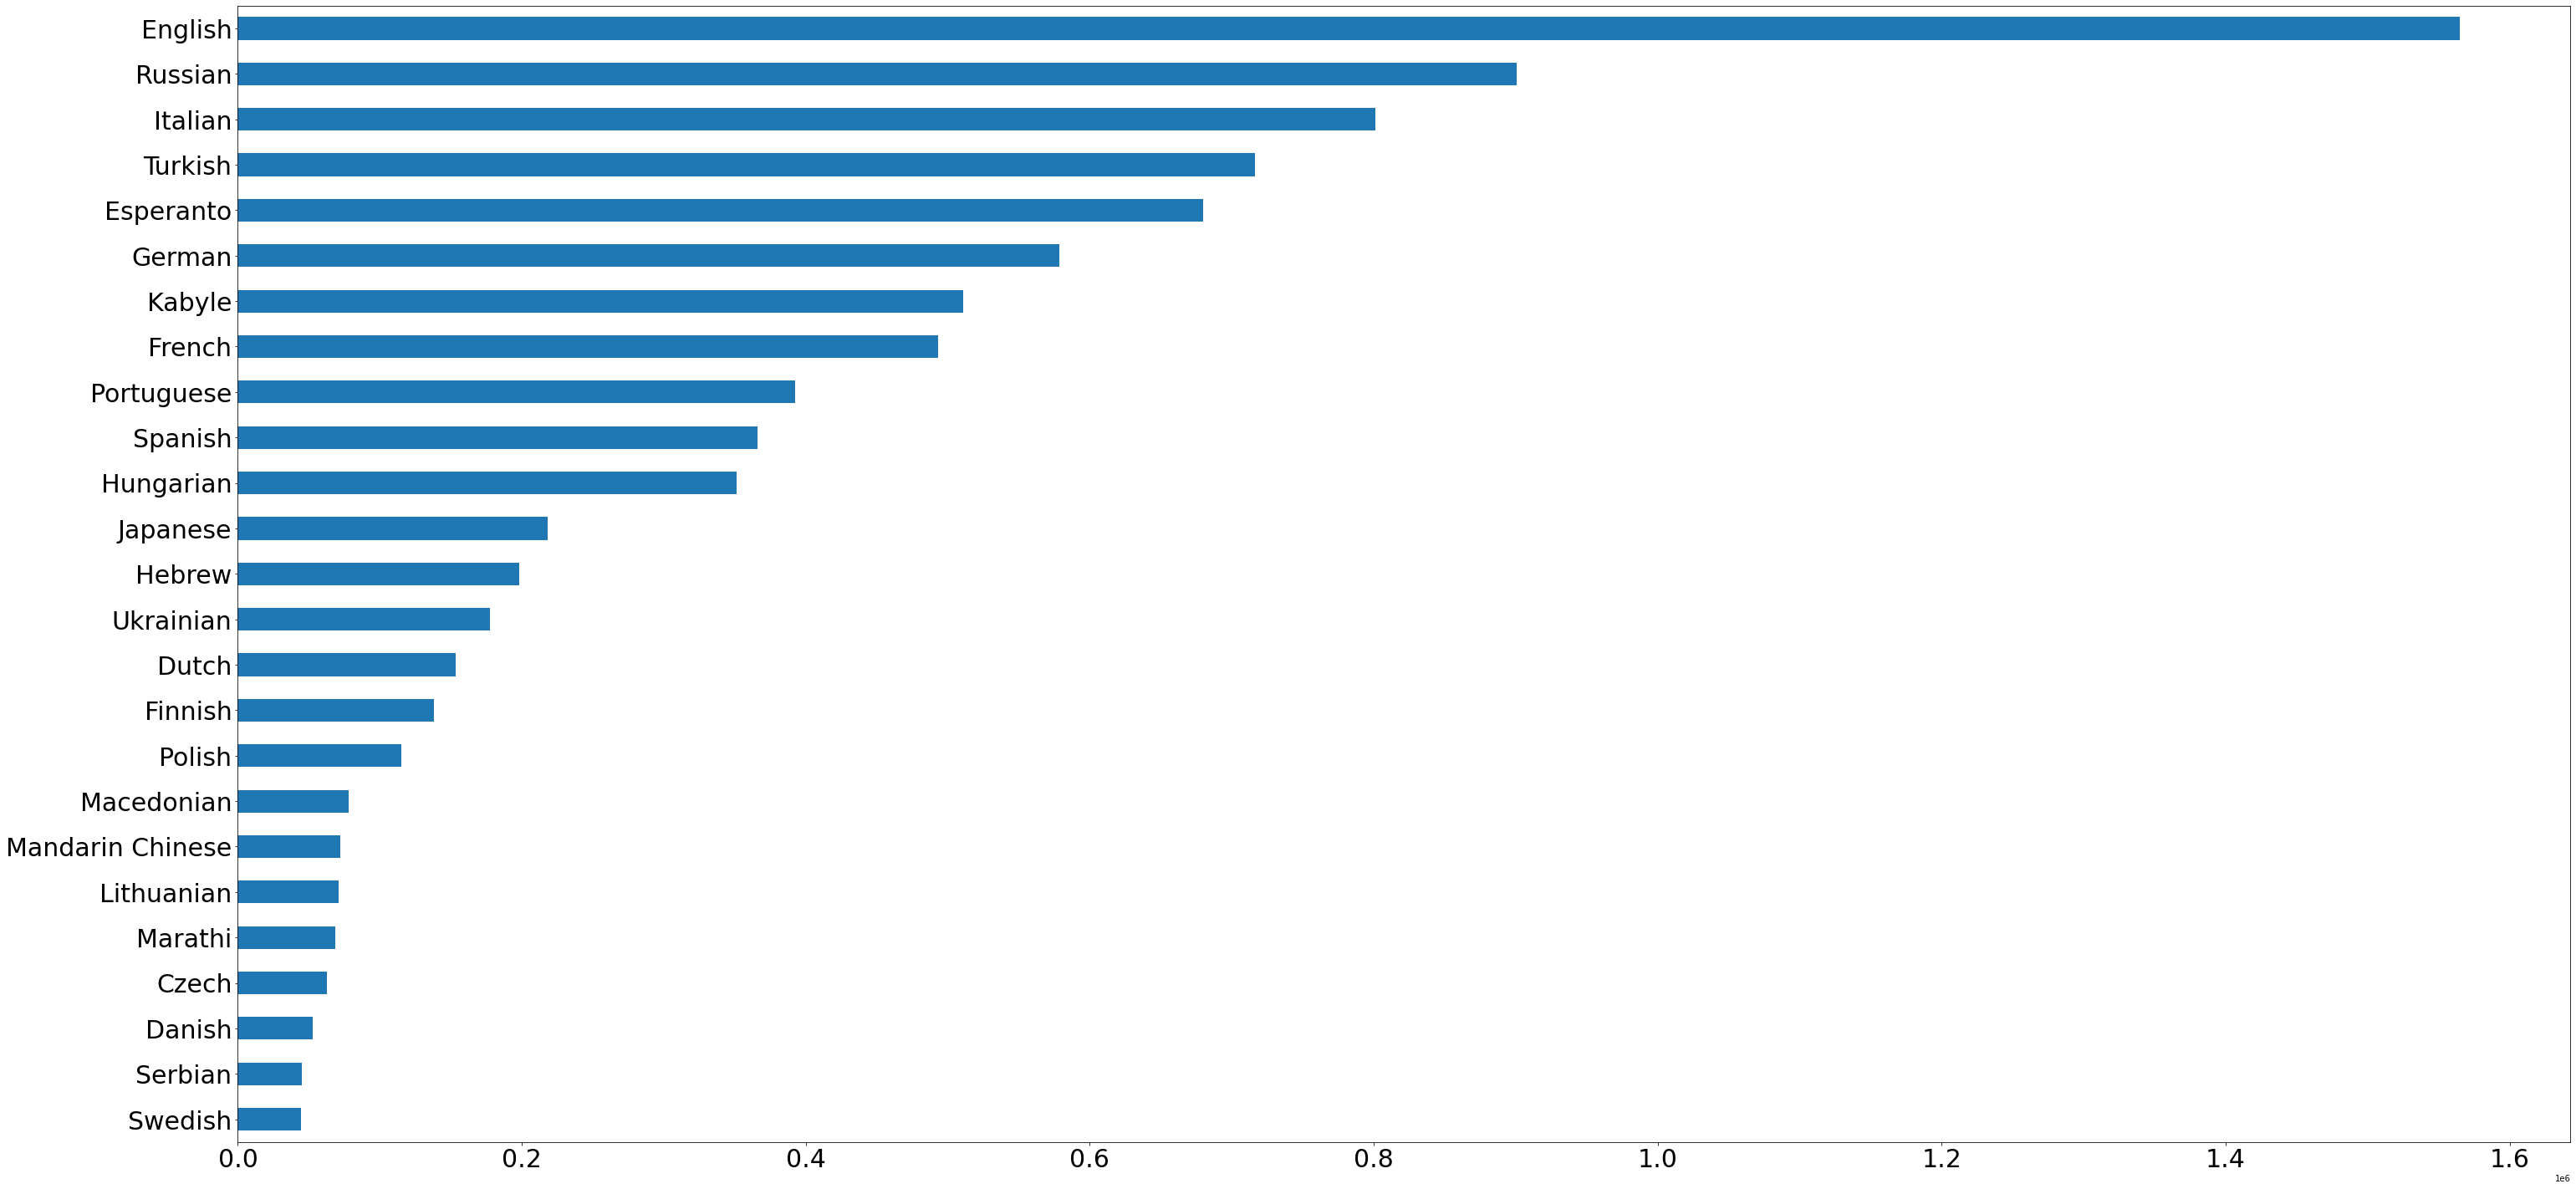

In [16]:
all_languages_codes_df['Ref_Name'].value_counts()[:25].sort_values(ascending=True)\
        .plot(kind='barh', figsize=(50,25), fontsize="30")

In [11]:
# Remove unneeded columns
top_languages_df = top_languages_df.drop(['index','Index','Scope','Language_Type'], axis=1)
top_languages_df.head()

,Sentence,Ref_Name
5859,ويل للكافرين,Arabic
5860,متى أنشئت هذه الجامعة؟,Arabic
5861,أراها نادراً,Arabic
5862,يعزف على البيانو بشكل جيد جداً,Arabic
5863,مع كل احترامي.,Arabic


In [12]:
# Go through each language, for languages with over 50,000 rows randomly sample 50,000 rows
# Need to shrink the dataset since CountVecotrize overloads computer
sample_lang_df = pd.DataFrame()
for lang in top_languages:
    df = top_languages_df[top_languages_df['Ref_Name'] == lang]
    if(df['Ref_Name'].count() > 500):
        sample_lang_df = sample_lang_df.append(df.sample(n=500))
    else:
        sample_lang_df = sample_lang_df.append(df)

sample_lang_df.shape
    

(9660, 2)

In [13]:
x = sample_lang_df['Sentence']
y = sample_lang_df['Ref_Name']

In [14]:
# Preprocess the data before doing Bag of Words
import re
preprocessed_data = []
for text in x:
    # remove symbols numbers and punctuation
    text = re.sub(r'[!@#$(),.n"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[[]]', ' ', text)
    text = text.lower()
    preprocessed_data.append(text)

<ipython-input-14-7171dbafdbec>:7: FutureWarning: Possible nested set at position 1
  text = re.sub(r'[[]]', ' ', text)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [17]:
# Create count vectorizer that uses 2-char ngrams instead of words
# Prevent an overwhelming number of features
cv = CountVectorizer(analyzer='char', ngram_range=(2,2))

pipeline = Pipeline([('vectorizer',cv), ('model',MultinomialNB())])

In [18]:
# Fit the pipeline and calculate predictions
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

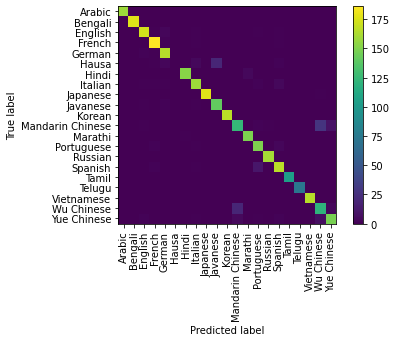

In [31]:
# Confusion matrix 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        xticks_rotation='vertical',
                                        include_values=False)
plt.show()

In [20]:
# Classification report
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

          Arabic       1.00      1.00      1.00       159
         Bengali       1.00      1.00      1.00       177
         English       0.96      0.96      0.96       180
          French       0.96      0.98      0.97       190
          German       0.93      0.98      0.96       168
           Hausa       0.00      0.00      0.00        30
           Hindi       0.99      0.97      0.98       157
         Italian       0.94      0.95      0.94       168
        Japanese       1.00      0.99      1.00       179
        Javanese       0.88      0.97      0.92       145
          Korean       1.00      0.99      1.00       168
Mandarin Chinese       0.83      0.75      0.79       165
         Marathi       0.97      0.99      0.98       150
      Portuguese       0.90      0.96      0.93       156
         Russian       0.99      1.00      1.00       161
         Spanish       0.93      0.92      0.93       181
           Ta

/Users/isabellasturm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabellasturm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/isabellasturm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [21]:
# Train a second model using the top 25 list based on the dataset counts
popular_languages = ['English', 'Russian', 'Italian',
                     'Turkish', 'Esperanto', 'German', 
                     'Kabyle', 'French', 'Portuguese',
                     'Spanish', 'Hungarian', 'Japanese',
                     'Hebrew', 'Ukrainian', 'Dutch',
                     'Finnish', 'Polish', 'Macedonian',
                     'Mandarin Chinese', 'Lithuanian',
                     'Marathi', 'Czech', 'Danish', 
                     'Serbian', 'Swedish']
popular_languages_df = all_languages_codes_df[all_languages_codes_df['Ref_Name'].isin(popular_languages)]
popular_languages_df = popular_languages_df.drop(['index', 'Index', 'Scope', 'Language_Type'], axis=1)

# Undersample majority classes to even out the datasets
sample_lang_df2 = pd.DataFrame()
for lang in popular_languages:
    df = popular_languages_df[popular_languages_df['Ref_Name'] == lang]
    if(df['Ref_Name'].count() > 50000):
        sample_lang_df2 = sample_lang_df2.append(df.sample(n=50000))
    else:
        sample_lang_df2 = sample_lang_df2.append(df)

print('Sample Dataset Shape: ',sample_lang_df2.shape)

x1 = sample_lang_df2['Sentence']
y1 = sample_lang_df2['Ref_Name']

# Pre-process the data
preprocessed_data = []
for text in x1:
    # remove symbols numbers and punctuation
    text = re.sub(r'[!@#$(),.n"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[\[\]]', ' ', text)
    text = text.lower()
    preprocessed_data.append(text)
    
# Split the dataset
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.33, random_state=42)

# Create count vectorizer and model
cv1 = CountVectorizer(analyzer='char', ngram_range=(2,2))
pipeline1 = Pipeline([('vectorizer',cv1), ('model',MultinomialNB())])

# Fit the pipline and calculate predictions
pipeline1.fit(x1_train, y1_train)
y1_pred = pipeline1.predict(x1_test)

# Classification Report
print(classification_report(y1_test, y1_pred))


Sample Dataset Shape:  (1239387, 2)
                  precision    recall  f1-score   support

           Czech       0.90      0.98      0.94     16306
          Danish       0.93      0.95      0.94     16612
           Dutch       0.97      0.95      0.96     16566
         English       0.95      0.98      0.96     16465
       Esperanto       0.92      0.98      0.95     16401
         Finnish       0.98      0.99      0.99     16486
          French       0.98      0.98      0.98     16723
          German       0.96      0.97      0.97     16384
          Hebrew       1.00      1.00      1.00     16573
       Hungarian       0.99      0.98      0.99     16557
         Italian       0.95      0.96      0.95     16532
        Japanese       1.00      1.00      1.00     16671
          Kabyle       1.00      0.99      0.99     16368
      Lithuanian       0.94      0.98      0.96     16425
      Macedonian       0.70      0.98      0.81     16415
Mandarin Chinese       1.00      1.

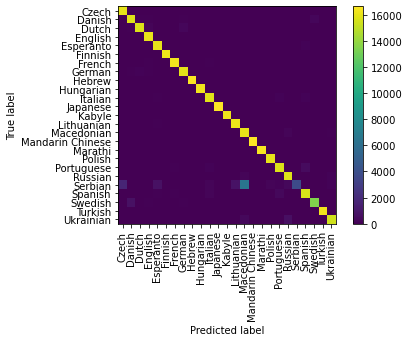

In [30]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y1_test, y1_pred,
                                        xticks_rotation='vertical',
                                        include_values=False)
plt.show()